# Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
import os

# Define the path for the new folder
new_folder_path = '/content/unzipped_folder'

# Create the folder
os.makedirs(new_folder_path, exist_ok=True)

# Verify that the folder has been created
os.listdir('/content')


['.config', 'unzipped_folder', 'train.csv', 'test.csv', 'sample_data']

# Load the data

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Understand The data

In [ ]:
print(train_df.sample(5))

                                      filename      category
375    result_table_img_63264_0_1698260758.jpg      bordered
295    result_table_img_34586_1_1684348769.jpg      bordered
753   result_table_img_100075_0_1711390266.jpg    borderless
1135   result_table_img_42349_0_1688686496.jpg  row_bordered
1145   result_table_img_26726_0_1679518884.jpg  row_bordered


In [ ]:
train_df.shape

(1257, 2)

In [ ]:
print(test_df.sample(5))

                                    filename    category
20   result_table_img_90028_1_1708548617.jpg    bordered
1    result_table_img_49176_0_1691792667.jpg    bordered
23   result_table_img_93139_0_1709562502.jpg    bordered
42   result_table_img_83636_0_1706648536.jpg    bordered
143  result_table_img_23698_0_1677599861.jpg  borderless


In [ ]:
test_df.shape

(300, 2)

#  Plot the distribution of categories in train and test data

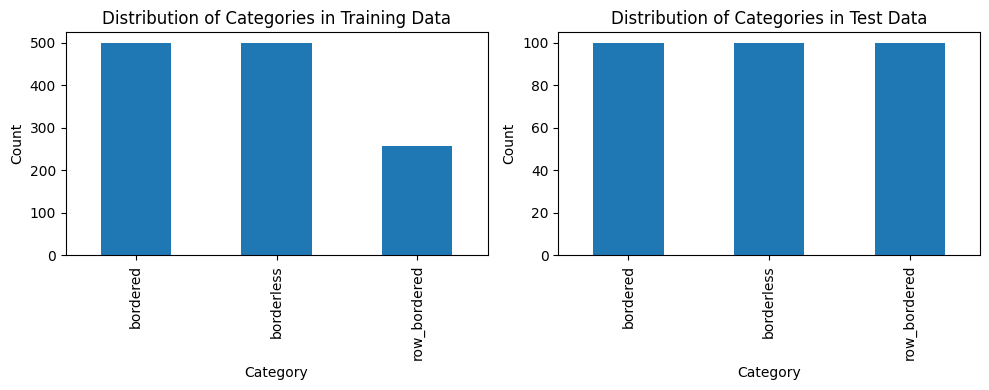

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
train_df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Categories in Training Data')
plt.xlabel('Category')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Categories in Test Data')
plt.xlabel('Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

The training data shows an imbalance with **row_bordered** having approximately half the number of samples compared to bordered and borderless. The test data, on the other hand, appears to be balanced across the three categories.

**Implications of Imbalance**
An imbalance in the training data can lead to the model being biased towards the categories with more samples (bordered and borderless in this case). This can result in lower accuracy for the row_bordered category.

# Preprocess the data

## Define image size and batch size

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

## ImageDataGenerator for training and validation

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    train_df,
    directory='/content/unzipped_folder/train',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    train_df,
    directory='/content/unzipped_folder/train',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1006 validated image filenames belonging to 3 classes.
Found 251 validated image filenames belonging to 3 classes.


# Build the model using a pre-trained VGG16

In [ ]:
num_classes = len(train_generator.class_indices)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
32/32 [==============================] - 64s 1s/step - loss: 2.8439 - accuracy: 0.3966 - val_loss: 1.8063 - val_accuracy: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 27s 842ms/step - loss: 1.0175 - accuracy: 0.4950 - val_loss: 1.2085 - val_accuracy: 0.0598
Epoch 3/5
32/32 [==============================] - 24s 754ms/step - loss: 0.8390 - accuracy: 0.6223 - val_loss: 0.6918 - val_accuracy: 0.8247
Epoch 4/5
32/32 [==============================] - 25s 779ms/step - loss: 0.6129 - accuracy: 0.7008 - val_loss: 0.5848 - val_accuracy: 0.8725
Epoch 5/5
32/32 [==============================] - 25s 768ms/step - loss: 0.5094 - accuracy: 0.7336 - val_loss: 0.6797 - val_accuracy: 0.8008


# Evaluate the model on test data

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory='/content/unzipped_folder/test',
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


Found 300 validated image filenames.
300/300 [==============================] - 12s 35ms/step


# Map predictions to class labels

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_classes]

# Save predictions to the CSV file

In [ ]:
test_df['category'] = predicted_labels
test_df.to_csv('predictions.csv', index=False)

# Print classification report

In [ ]:
print(classification_report(test_df['category'], predicted_labels))


              precision    recall  f1-score   support

    bordered       1.00      1.00      1.00       150
  borderless       1.00      1.00      1.00       121
row_bordered       1.00      1.00      1.00        29

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



# Confusion matrix

In [ ]:
cm = confusion_matrix(test_df['category'], predicted_labels)

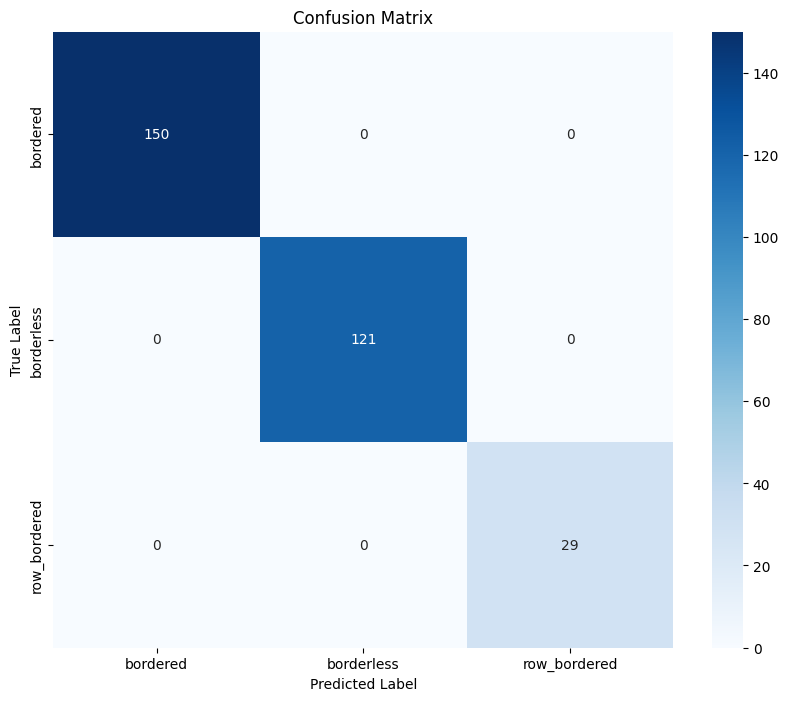

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history

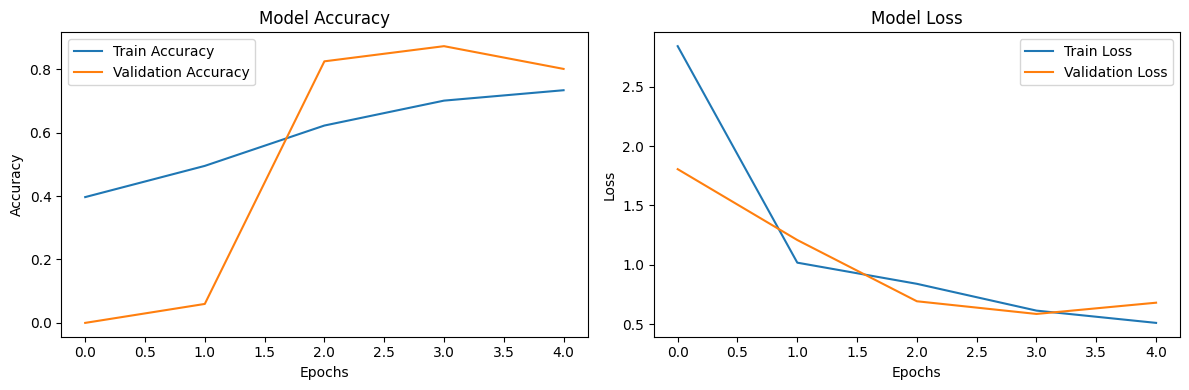

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Interpretation:**


**Accuracy Graph:**

Initially, the training and validation accuracy are both low, indicating that the model is learning.
As training progresses, both accuracies increase, indicating that the model is improving.
Around epoch 2 to 3, the validation accuracy surpasses the training accuracy. This is somewhat unusual and could be due to the small size of the validation set or random fluctuations.
By epoch 3 to 4, the validation accuracy starts to decrease while the training accuracy continues to increase, suggesting potential overfitting. Overfitting happens when the model performs well on the training data but not on the validation data.



**Loss Graph:**

The training and validation loss both decrease initially, indicating that the model is learning and improving.
Around epoch 3, the training loss continues to decrease while the validation loss starts to increase slightly, which is another indication of overfitting.


**Conclusion:**
The model seems to perform best around epoch 3, after which overfitting may start to occur.
Recommendation: You might want to consider using early stopping to halt training once the validation accuracy starts to decrease or the validation loss starts to increase. Additionally, you can experiment with different regularization techniques, such as dropout or weight decay, to prevent overfitting.

# Calculate performance metrics

In [ ]:

total_predictions = np.sum(cm)
correct_predictions = np.trace(cm)
accuracy = correct_predictions / total_predictions
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1 Score: {np.mean(f1_score):.2f}')

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


# Inference pipeline function

In [ ]:
def predict_image(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = labels[predicted_class[0]]
    probabilities = predictions[0]
    return predicted_label, probabilities

# usage of the inference function

In [ ]:
image_path = '/content/unzipped_folder/train/1321_E_UNION_BOM.png'
label, probs = predict_image(image_path, model)
print(f'Predicted label: {label}')
print(f'Class probabilities: {probs}')

1/1 [==============================] - 0s 33ms/step
Predicted label: bordered
Class probabilities: [0.7111199  0.01874461 0.27013546]
